# Imports necessários e o carro que você gostaria de se basear para recomendar

In [200]:
# Imports

import os, shutil, csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from google_images_downloader import GoogleImagesDownloader
from sklearn.neighbors import NearestNeighbors
from matplotlib.table import table
from unidecode import unidecode


In [201]:
recommend_like = 'Ford-EcoSport'
recommend_for_user = 169

is_it_by_user = True

# Leitura dos Datasets
O que eu preciso?
1) Um [dataset](https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews/data?select=Scraped_Car_Review_mazda.csv) que contém o id do usuário e um rating para um veículo, também com o ID dele 
2) Um [dataset](https://www.kaggle.com/datasets/robsonnovato/car-features) que contém o id do veículo com suas características

In [202]:
# Funções auxiliares

def ler_csv_para_dataframe(caminho_arquivo_csv):
    with open(caminho_arquivo_csv, 'r', newline='', encoding='utf-8') as arquivo_csv:
        leitor_csv = csv.reader(arquivo_csv)
        linhas = list(leitor_csv)        
    df = pd.DataFrame(linhas[1:], columns=linhas[0])
    return df
    
def renomear_arquivos_na_pasta(pasta, palavra_antiga, palavra_nova):
    for nome_arquivo in os.listdir(pasta):
        caminho_arquivo_antigo = os.path.join(pasta, nome_arquivo)
        if palavra_antiga in nome_arquivo:
            novo_nome_arquivo = nome_arquivo.replace(palavra_antiga, palavra_nova)
            caminho_arquivo_novo = os.path.join(pasta, novo_nome_arquivo)
            os.rename(caminho_arquivo_antigo, caminho_arquivo_novo)
    print("Arquivos renomeados com sucesso!")

def obter_nomes_apos_substring(pasta):
    nomes_extraidos = []
    for nome_arquivo in os.listdir(pasta):
        if "Scraped_Car_Review_" in nome_arquivo:
            parte_nome = nome_arquivo.split("Scraped_Car_Review_")[1].replace(".csv", "")
            nomes_extraidos.append(parte_nome)
    return nomes_extraidos

In [203]:
# Tratamento dos arquivos nas pastas do dataset baixado (alguns nomes são inconsistentes)

pasta = './Data/'
palavra_antiga = "Reviews"
palavra_nova = "Review"
renomear_arquivos_na_pasta(pasta, palavra_antiga, palavra_nova)

palavra_antiga = "Scrapped"
palavra_nova = "Scraped"
renomear_arquivos_na_pasta(pasta, palavra_antiga, palavra_nova)

Arquivos renomeados com sucesso!
Arquivos renomeados com sucesso!


In [204]:
# Upload dos datasets

marcas_de_carro = obter_nomes_apos_substring("./Data/")
todos_df = []

for marca in marcas_de_carro:
    file_path = f'./Data/Scraped_Car_Review_{marca}.csv'
    df = ler_csv_para_dataframe(file_path)
    df = df.drop(["Review_Title", "Review", "Review_Date", ""], axis=1)
    todos_df.append(df)

ratings = pd.concat(todos_df, ignore_index=True)
ratings = ratings.dropna()

# Tratativas

In [205]:
# 1) Criar um ID unico para cada comprador

author_to_id = {}
for i, author in enumerate(ratings["Author_Name"].unique()):
    author_to_id[author] = i
ratings["userID"] = ratings["Author_Name"].apply(lambda author: author_to_id[author])

In [206]:
# 2) Algumas tratativas do dataset de usuarios

ratings['Company'] = ratings['Vehicle_Title'].str.split().str[1]
ratings['Vehicle_Title'] = ratings['Vehicle_Title'].str.split().str[2:]
ratings['Vehicle_Title'] = ratings['Vehicle_Title'].str.join(' ')
ratings['Model'] = ratings['Vehicle_Title'].str.split().str[0]
ratings = ratings.drop("Vehicle_Title", axis=1)

ratings['carID'] = ratings['Company'].astype(str) + '-' + ratings['Model'].astype(str)

In [207]:
# 3) Algumas tratativas do dataset de veiculos

cars = pd.read_csv('cars.csv')
cars['carID'] = cars['Company'].astype(str) + '-' + cars['Model'].astype(str)

substituicoes = {
    'cupe': 'coupe',
    'seda': 'sedan',
    'convertible': 'conversivel',
    'hatch': 'hatchback',
    'pick-up': 'picape',
    'pickup': 'picape',
    'hatchback eletrico': 'hatchback',
    'sports car': 'esportivo',
    'hatchback esportivo': 'hatchback',
    'station wagon': 'wagon',
    'truck': 'minivan',
    'seda de luxo': 'sedan',
    'crossover': 'suv',
    'hibrido': 'sedan',
    'furgao': 'van',
    'cabriolet': 'conversivel',
    'subcompacto': 'compacto',
    'media': 'picape',
    'muscle car': 'esportivo'
}

cars['bodytype'] = cars['bodytype'].str.lower().apply(unidecode).replace(substituicoes)
valores_unicos_bodytype = cars['bodytype'].unique()

mapeamento_numerico = {}
for bodytype in valores_unicos_bodytype:
    index = len(mapeamento_numerico) + 1
    mapeamento_numerico[bodytype] = index
cars['bodytype'] = cars['bodytype'].map(mapeamento_numerico)

# Análises estatísticas

In [208]:
n_ratings = len(ratings)
n_cars = len(ratings['carID'].unique())
n_users = len(ratings['userID'].unique())

print(f"Numero de ratings: {n_ratings}")
print(f"Numero de veiculos unicos: {n_cars}")
print(f"Numero de avaliadores unicos: {n_users}")
print(f"Rating medio por avaliador: {round(n_ratings/n_users, 2)}")
print(f"Numero medio de rating por veiculo: {round(n_ratings/n_cars, 2)}")

Numero de ratings: 215387
Numero de veiculos unicos: 630
Numero de avaliadores unicos: 154991
Rating medio por avaliador: 1.39
Numero medio de rating por veiculo: 341.88


In [209]:
ratings['Rating'] = ratings['Rating'].astype(float)
mean_rating = ratings.groupby('carID')[['Rating']].mean()
lowest_rated = mean_rating['Rating'].idxmin()
cars.loc[cars['carID'] == lowest_rated]
highest_rated = mean_rating['Rating'].idxmax()
cars.loc[cars['carID'] == highest_rated]
ratings[ratings['carID']==highest_rated]
ratings[ratings['carID']==lowest_rated]

car_stats = ratings.groupby('carID')[['Rating']].agg(['count', 'mean'])
car_stats.columns = car_stats.columns.droplevel()

In [210]:
# Ver quais usuários tem mais ratings

ratings_grouped = ratings.groupby('userID')
n_ratings_per_user = ratings_grouped.size()
ratings_grouped_sorted = ratings_grouped.size().sort_values(ascending=False)
top_10_users = ratings_grouped_sorted.head(10)

for user_id, num_ratings in top_10_users.items():
    print(f"O usuário {user_id} possui {num_ratings} ratings.")

O usuário 156 possui 894 ratings.
O usuário 169 possui 793 ratings.
O usuário 1759 possui 572 ratings.
O usuário 114 possui 558 ratings.
O usuário 140 possui 530 ratings.
O usuário 146 possui 511 ratings.
O usuário 1720 possui 464 ratings.
O usuário 148 possui 461 ratings.
O usuário 1752 possui 439 ratings.
O usuário 735 possui 430 ratings.


# Método de recomendação por KNN

In [211]:
def create_matrix(df):
	N = len(df['userID'].unique())
	M = len(df['carID'].unique())
	user_mapper = dict(zip(np.unique(df["userID"]), list(range(N))))
	car_mapper = dict(zip(np.unique(df["carID"]), list(range(M))))
	user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userID"])))
	car_inv_mapper = dict(zip(list(range(M)), np.unique(df["carID"])))
	user_index = [user_mapper[i] for i in df['userID']]
	car_index = [car_mapper[i] for i in df['carID']]
	X = csr_matrix((df["Rating"], (car_index, user_index)), shape=(M, N))
	return X, user_mapper, car_mapper, user_inv_mapper, car_inv_mapper

In [212]:
def find_similar_cars(recommend_like, X, k, car_mapper, car_inv_mapper, metric='cosine',  show_distance=False):
	neighbour_ids = []
	car_ind = car_mapper[recommend_like]
	car_vec = X[car_ind]
	k+=1
	kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
	kNN.fit(X)
	car_vec = car_vec.reshape(1,-1)
	neighbour = kNN.kneighbors(car_vec, return_distance=show_distance)
	for i in range(0,k):
		n = neighbour.item(i)
		neighbour_ids.append(car_inv_mapper[n])
	neighbour_ids.pop(0)
	return neighbour_ids

In [213]:
X, user_mapper, car_mapper, user_inv_mapper, car_inv_mapper = create_matrix(ratings)
carros_recomendados = []

def find_car_based_in_example():
    similar_ids = find_similar_cars(recommend_like, X, 3, car_mapper, car_inv_mapper)

    car_titles = dict(zip(cars['carID'], cars['carID']))
    car_title = car_titles[recommend_like]
    carros_recomendados.append(car_title)

    for i in similar_ids:
        carros_recomendados.append(car_titles[i])

In [214]:
def recommend_cars_for_user(user_id, X, user_mapper, car_mapper, car_inv_mapper, k=10):
	df1 = ratings[ratings['userID'] == user_id]
	
	if df1.empty:
		print(f"User with ID {user_id} does not exist.")
		return

	car_id = df1[df1['Rating'] == max(df1['Rating'])]['carID'].iloc[0]

	car_titles = dict(zip(cars['carID'], cars['carID']))

	similar_ids = find_similar_cars(car_id, X, k, car_mapper, car_inv_mapper)
	car_title = car_titles.get(car_id, "Carro não encontrado")
	carros_recomendados.append(car_title)

	if car_title == "Carro não encontrado":
		print(f"Carro com id: {car_id} não encontrado.")
		return

	for i in similar_ids:
		carros_recomendados.append(car_titles[i])

In [215]:
if is_it_by_user:
    recommend_cars_for_user(recommend_for_user, X, user_mapper, car_mapper, car_inv_mapper, k=3)
else:
    find_car_based_in_example()

# Funções de plotagem dos veículos recomendados

In [216]:
# Download das imagens

def baixar_imagens(array_de_carros):
    downloader = GoogleImagesDownloader(browser="chrome", show=False, debug=False, quiet=False, disable_safeui=False) 
    for carro in array_de_carros:
        downloader.download(carro, limit=1, destination="./carros-sugeridos", file_format="PNG")
    downloader.close()

In [217]:
def plotar_carros(array_de_carros):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, ax in enumerate(axs.flatten()):
        carro = array_de_carros[i]
        image_path = f'./carros-sugeridos/{carro}/{carro}_0.png'

        if os.path.exists(image_path):
            image = plt.imread(image_path)
            ax.imshow(image)
            ax.set_title(carro)
            ax.axis('off')
        else:
            ax.axis('off')
            ax.set_title(f'Imagem não encontrada para {carro}')

    plt.show()


In [218]:
def excluir_pasta(caminho_pasta):
    if os.path.exists(caminho_pasta):
        shutil.rmtree(caminho_pasta)
    else:
        print(f"A pasta {caminho_pasta} não existe.")

In [219]:
def criar_tabela(ax, dados, headers):
    tabela = table(ax, cellText=dados, colLabels=headers, loc='center')
    tabela.auto_set_font_size(False)
    tabela.set_fontsize(10)
    tabela.scale(4, 1.2)
    for i in range(len(headers)):
        tabela[(0, i)].set_facecolor("#a6a6a6") 
        tabela[(1, i)].set_facecolor("red")
    ax.axis('off')
    return tabela

def apresentar_tabela(lista_de_carros_recomendados):
    headers = ['Carro', 'Cavalos', 'Marchas', 'Preço Médio', 'Bodytype', 'Cilindros', 'km/l', 'Lugares']
    dados = []
    mapeamento_string_para_numerico = {v: k for k, v in mapeamento_numerico.items()}
    for i in lista_de_carros_recomendados:
        carro_recomendado = cars.loc[cars['carID'] == i]
        dados.append([
            i,
            carro_recomendado['Cavalos'].values[0],
            carro_recomendado['Marchas'].values[0],
            f'R${carro_recomendado["Preço médio"].values[0]:.2f}',
            mapeamento_string_para_numerico.get(carro_recomendado['bodytype'].values[0], 'Não encontrado'),
            carro_recomendado['cilindros'].values[0],
            carro_recomendado['km/l'].values[0],
            carro_recomendado['lugares'].values[0],
        ])
    fig, ax = plt.subplots()
    tabela = criar_tabela(ax, dados, headers)
    plt.show()


In [220]:
def criar_grafico_barras_por_ids(ids):
    instancias_selecionadas = cars[cars['carID'].isin(ids)]
    plt.figure(figsize=(10, 6))
    plt.bar(instancias_selecionadas['carID'], instancias_selecionadas['Preço médio'], color='blue')
    
    plt.xlabel('IDs')
    plt.ylabel('Preço Médio')
    plt.title('Preço Médio por ID')
    
    plt.show()

In [221]:
def plotagem(lista_de_carros, tem_carro_base=False):
    if tem_carro_base:
        print(f"Se voce gostou de {lista_de_carros[0]}, pode gostar de:")
        for carro in lista_de_carros[1:]:
            print(carro)
    else:
        print(f"Carros recomendados:")
        for carro in lista_de_carros:
            print(carro)
    print("\n\n")
    baixar_imagens(lista_de_carros)
    plotar_carros(lista_de_carros)
    apresentar_tabela(lista_de_carros)
    criar_grafico_barras_por_ids(lista_de_carros)
    excluir_pasta("./carros-sugeridos/")

# Plotar veículos recomendados

Se voce gostou de Lotus-Elise, pode gostar de:
Chevrolet-Silverado
Honda-Civic
Ford-F-150





Scrolling...
Downloading...


100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Scrolling...
Downloading...


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Scrolling...
Downloading...


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Scrolling...
Downloading...


100%|██████████| 1/1 [00:30<00:00, 30.90s/it]


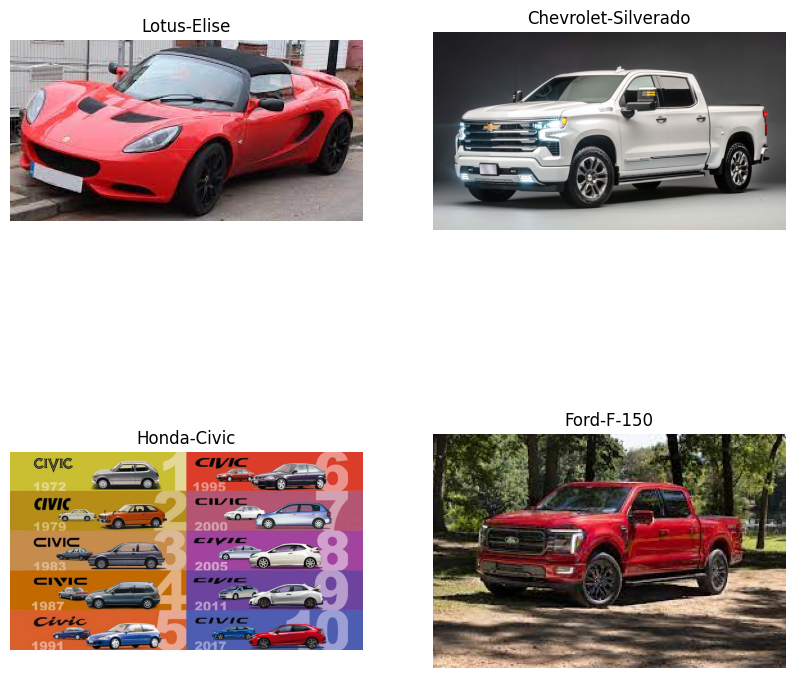

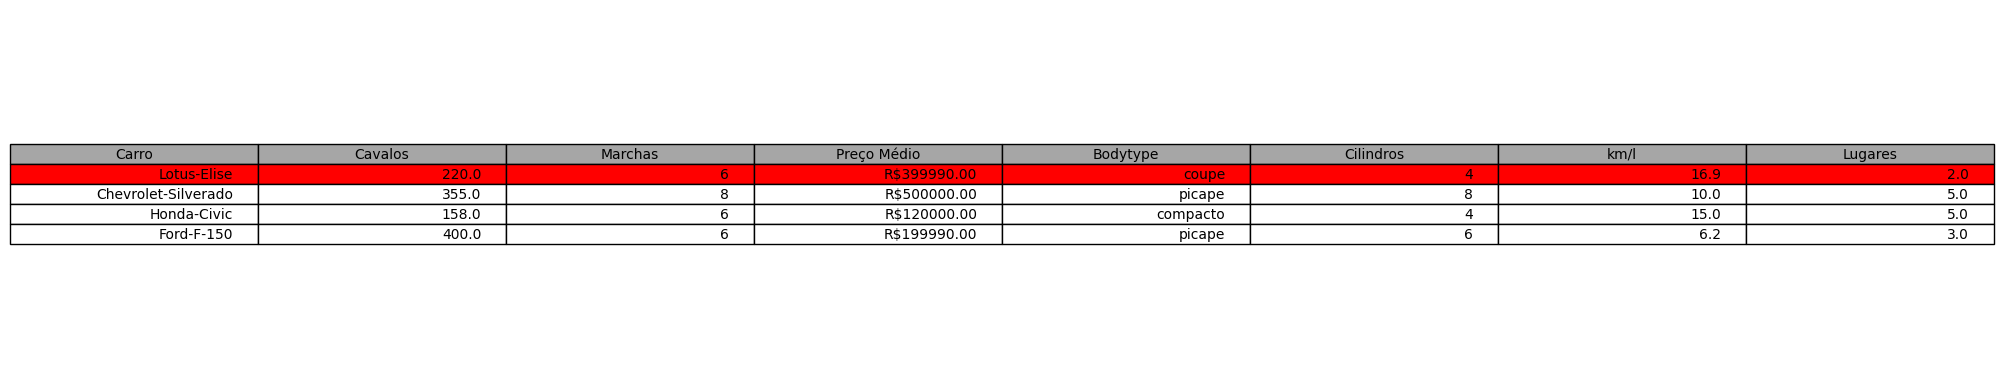

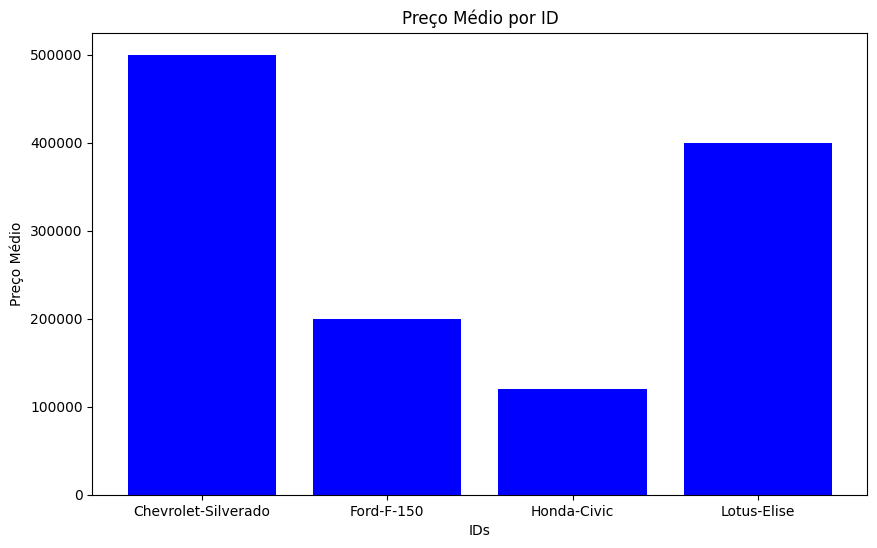

In [222]:
plotagem(carros_recomendados, tem_carro_base=True)